### Job Posting Scraper and Parser

The objective of this project is to scrape Indeed.ca to collect job postings and then process them to extract the most commonly listed skills on those job postings into a WordCloud. The purpose is to aid your job search to quickly identify what are some of the most requested skills for a job you are looking for. In this project, I am using "Data Analyst" as the job title of interest.

This project uses numerous libraries including Pandas, Numpy, BeautifulSoup, NLTK, Scikit-Learn, and WordCloud.

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import collections
import re
import string

import nltk
from nltk import stem
# nltk.download('punkt')    # Sentence tokenizer
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import requests

In [2]:
# User Agent header
hd = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"}

In [3]:
# Define function to prompt user input for position
def obtain_job_title():
    job_title = str.lower(input('Enter job title:'))
    return job_title

In [4]:
# Define function to prompt user input for location
def obtain_location():
    location = str.lower(input('Enter location:'))
    return location

In [5]:
# Define function to primpt user input for number of pages to be scraped
def obtain_page_range():
    page = int(input('Enter number of pages of search results (not recommended to exceed 10 pages):'))
    return page

In [6]:
# Define function to generate search page URLs

# Instantiate list for job terms
# Note: this list won't be populated when this specific cell is executed; a subsequent function will call this function and that's the point where it will store the values
job_terms = []

def generate_page_urls():
    # Obtain all user-inputted search parameters
    job_title = obtain_job_title()
    location = obtain_location()
    page = obtain_page_range()

    # Store job title input, make lower case, split elements, append to list
    job_title = re.sub('-', ' ', job_title)
    job_title = re.sub(r'[^A-Za-z0-9 ]+', '', job_title)
    job_title_split = job_title.split()
    job_terms.append(job_title_split)

    # Build search page URLs with user-inputted search parameters
    base_url = 'https://ca.indeed.com' 
    page_url_list = []
    for i in (np.arange(page) * 10):    # Multiply by 10 because each page is represented in the URL by increments of 10 (first page starts at 0)
        page_url = 'https://ca.indeed.com/jobs?q={}&l={}&start={}'.format(job_title, location, i)
        page_url_list.append(page_url)
    return page_url_list

In [7]:
# Define function to extract job posting links
def fetch_job_links():
    base_url = 'https://ca.indeed.com'
    urls = generate_page_urls()
    job_links = []
    for url in urls:
        get_html = requests.get(url, headers=hd)
        soup = BeautifulSoup(get_html.text, 'html.parser')

        # Get all links on a search page
        links = []
        for link in soup.find_all('a'):
            links.append(base_url + str(link.get('href')))
        print(links)
    
        # Filter for links to full job postings only and append to job_links list
        for link in links:
            if ('/rc/clk' in link) or ('/company/' in link):
                job_links.append(link)
        
    return job_links

In [8]:
# Define function to create a dataframe of all job descriptions extracted
def create_df_job_description():
    job_links = fetch_job_links()
    df = pd.DataFrame(columns=['job_title', 'job_description', 'job_link'])
    
    # For every job link collected, extract HTML
    for job_link in job_links:
        get_html = requests.get(job_link, headers=hd)
        soup = BeautifulSoup(get_html.text, 'html.parser')

        # Look for div class tag for job description
        # Use try / except here because the specific div class tag may not longer be used sometime in the future
        try:
            job_title = soup.find('h1',{'class': 'icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title'}).text
        except:
            continue
        
        try:
            job_description = soup.find('div', {'class': 'jobsearch-jobDescriptionText'}).text
        except:
            continue

        df = df.append({'job_title': job_title, 'job_description': job_description, 'job_link': job_link}, ignore_index=True)
    
    return df

In [10]:
# %%capture
# # Run function to create dataframe of all live-extracted job description
# df = create_df_job_description()

In [ ]:
# # Check df dimensions
# len(df)

In [ ]:
# # If web scrape successful, create a 2nd df to compare it against the last saved file (which can be read into df)
# # Will use whichever file has a higher number of filtered job titles
# df2 = df.copy()

In [ ]:
# # Output new Excel file if data scraping is successful (and if df2 is the larger dataframe, overwrite the Excel file)
# df2.to_excel('df_job_descriptions.xlsx', sheet_name='main', index=False)

In [11]:
# If scraping blocked due to too many requests, switch to assign df to read from an Excel file previously extracted
# The last successful scrape pulled 50 pages of job postings (over 500+ individual postings)
df = pd.read_excel('df_job_descriptions.xlsx')

In [12]:
# Check df, dimensions, and null count
display(df.head())
print('Rows, columns:', df.shape)
print('Null count:')
print(df.isnull().sum())

,job_title,job_description,job_link
0,"Data Analyst, Forensic Disputes",Job Type: Permanent\nPrimary Location: Multipl...,https://ca.indeed.com/rc/clk?jk=fdf59813de705f...
1,Junior Data Analyst,"Blend is a Recruitment Process Outsourcer, who...",https://ca.indeed.com/rc/clk?jk=7ace67b6efdea6...
2,Junior Data Analyst,The Revenue Management Opportunity\n\nWe are c...,https://ca.indeed.com/rc/clk?jk=4bdcb993fbbfdb...
3,People Data Analyst,Who we are:\nlululemon is a yoga-inspired tech...,https://ca.indeed.com/rc/clk?jk=e546e664d82f13...
4,Data Analyst,"Req Id: 359760\nAt Bell, we do more than build...",https://ca.indeed.com/rc/clk?jk=0761c0ebadc086...


Rows, columns: (565, 3)
Null count:
job_title          0
job_description    0
job_link           0
dtype: int64


In [13]:
# Removing nesting in the job terms list
# Will use this to filter out the scraped job postings for only titles that contain all of the job terms in this list variable
job_terms = job_terms[0]
print(job_terms)

['data', 'analyst']


In [14]:
# Create custom function to clean up column - make all lower case and remove special characters
def clean_columns(c):
    df[c] = df[c].str.lower()
    for i in df.index:
        df[c][i] = re.sub(r'[^A-Za-z0-9 ]+', ' ', df[c][i])
    return df

In [15]:
%%capture
# Apply cleaning function to job title
clean_columns('job_title')

In [16]:
# Check cleaned up job titles
df.head()

,job_title,job_description,job_link
0,data analyst forensic disputes,Job Type: Permanent\nPrimary Location: Multipl...,https://ca.indeed.com/rc/clk?jk=fdf59813de705f...
1,junior data analyst,"Blend is a Recruitment Process Outsourcer, who...",https://ca.indeed.com/rc/clk?jk=7ace67b6efdea6...
2,junior data analyst,The Revenue Management Opportunity\n\nWe are c...,https://ca.indeed.com/rc/clk?jk=4bdcb993fbbfdb...
3,people data analyst,Who we are:\nlululemon is a yoga-inspired tech...,https://ca.indeed.com/rc/clk?jk=e546e664d82f13...
4,data analyst,"Req Id: 359760\nAt Bell, we do more than build...",https://ca.indeed.com/rc/clk?jk=0761c0ebadc086...


In [17]:
# Filters main dataframe if the job title contains all the job terms that was inputted by the user
# I.e. we only want job titles that contain "Data Analyst" (so we don't want to see a job like Business Analyst or QC Analyst)
job_terms_subset = set(job_terms).issubset
df = df[[job_terms_subset(l) for l in df['job_title'].str.split()]]
df = df.reset_index(drop=True)
display(df.head())
print('Rows, columns:', df.shape)

,job_title,job_description,job_link
0,data analyst forensic disputes,Job Type: Permanent\nPrimary Location: Multipl...,https://ca.indeed.com/rc/clk?jk=fdf59813de705f...
1,junior data analyst,"Blend is a Recruitment Process Outsourcer, who...",https://ca.indeed.com/rc/clk?jk=7ace67b6efdea6...
2,junior data analyst,The Revenue Management Opportunity\n\nWe are c...,https://ca.indeed.com/rc/clk?jk=4bdcb993fbbfdb...
3,people data analyst,Who we are:\nlululemon is a yoga-inspired tech...,https://ca.indeed.com/rc/clk?jk=e546e664d82f13...
4,data analyst,"Req Id: 359760\nAt Bell, we do more than build...",https://ca.indeed.com/rc/clk?jk=0761c0ebadc086...


Rows, columns: (326, 3)


In [18]:
%%capture
# Clean up job descriptions
clean_columns('job_description')

In [19]:
# Check cleaned up job descriptions
df.head()

,job_title,job_description,job_link
0,data analyst forensic disputes,job type permanent primary location multiple...,https://ca.indeed.com/rc/clk?jk=fdf59813de705f...
1,junior data analyst,blend is a recruitment process outsourcer who...,https://ca.indeed.com/rc/clk?jk=7ace67b6efdea6...
2,junior data analyst,the revenue management opportunity we are curr...,https://ca.indeed.com/rc/clk?jk=4bdcb993fbbfdb...
3,people data analyst,who we are lululemon is a yoga inspired techni...,https://ca.indeed.com/rc/clk?jk=e546e664d82f13...
4,data analyst,req id 359760 at bell we do more than build ...,https://ca.indeed.com/rc/clk?jk=0761c0ebadc086...


In [20]:
# Remove urls from any job descriptions and append all job descriptions into a single list
job_description_links_removed = []

for j in df['job_description']:
    if re.findall(r'(https?://\S+)', j):
        job_description_links_removed.append(re.sub(r'(https?://\S+)', ' ', j))
    else:
        job_description_links_removed.append(j)

In [21]:
# Prep to identify top keywords across all job postings collected
# First put all job descriptions into a single list and join into a single string so we can tokenize
job_description_joined = ''.join(job_description_links_removed)

In [22]:
# Tokenize words for all job descriptions
word_tokens = nltk.word_tokenize(job_description_joined)

In [23]:
# Stopwords using the base dictionary provided by NTLK and extend the list manually for additional tweaking
stop_words = set(stopwords.words('english'))

# Remove some additional words that are not particularly useful
additional_words = pd.read_excel('additional_words.xlsx', usecols=[0])
additional_words_list = []

for w in additional_words['Additional Words']:
    additional_words_list.append(w)

for e in additional_words_list:
    stop_words.add(e)

# Remove stop words on list of job descriptions and return all non-stop words into a new list
clean_words = []
for w in word_tokens:
    if w not in stop_words:
        clean_words.append(w)

clean_words

['type',
 'permanent',
 'primary',
 'location',
 'multiple',
 'locations',
 'ontario',
 'canada',
 'available',
 'locations',
 'toronto',
 'burlington',
 'kitchener',
 'london',
 'ottawa',
 'vaughan',
 'windsor',
 'purpose',
 'deloitte',
 'driven',
 'inspire',
 'help',
 'organization',
 'communities',
 'country',
 'thrive',
 'purpose',
 'build',
 'better',
 'future',
 'accelerating',
 'expanding',
 'access',
 'purpose',
 'defines',
 'gives',
 'reason',
 'exist',
 'organization',
 'living',
 'purpose',
 'make',
 'impact',
 'matters',
 'learn',
 'deep',
 'subject',
 'matter',
 'experts',
 'mentoring',
 'coaching',
 'partner',
 'clients',
 'solve',
 'complex',
 'problems',
 'expected',
 'share',
 'ideas',
 'make',
 'reality',
 'want',
 'stimulating',
 'dynamic',
 'environment',
 'ambitious',
 'colleagues',
 'share',
 'interests',
 'want',
 'play',
 'crucial',
 'role',
 'execution',
 'various',
 'litigation',
 'engagements',
 'position',
 'typical',
 'day',
 'look',
 'like',
 'remediation'

In [24]:
# Lemmatize all words to retrieve root form (and remove word endings)
lemmatizer = stem.WordNetLemmatizer()
clean_words_lemmatized = [lemmatizer.lemmatize(w) for w in clean_words]

In [25]:
# Vectorize the cleaned words list
vectorizer = TfidfVectorizer(input='content', use_idf=True)
vectors = vectorizer.fit_transform(clean_words_lemmatized).toarray()
vocab = np.array(vectorizer.get_feature_names_out())

In [26]:
# Check scores of word importance
scores = {'Words': vocab, 'Scores': sum(vectors)}
df_scores = pd.DataFrame(data=scores)
df_scores.sort_values(by=['Scores'], ascending=False, inplace=True)
df_scores[:31]

,Words,Scores
4657,management,681.0
6852,service,537.0
6403,reporting,530.0
6399,report,484.0
2131,customer,480.0
7767,tool,480.0
7492,system,478.0
6435,required,467.0
5963,project,461.0
7604,technology,441.0


In [27]:
# Calculate N most frequent words
n = 30
freq_count = collections.Counter(clean_words)

# Create new dataframe for word counts
df_word_counts = pd.DataFrame(freq_count.most_common(n), columns=['Words', 'Count'])
df_word_counts

,Words,Count
0,management,681
1,reporting,530
2,required,467
3,tools,458
4,development,412
5,role,394
6,related,391
7,quality,389
8,reports,386
9,canada,369


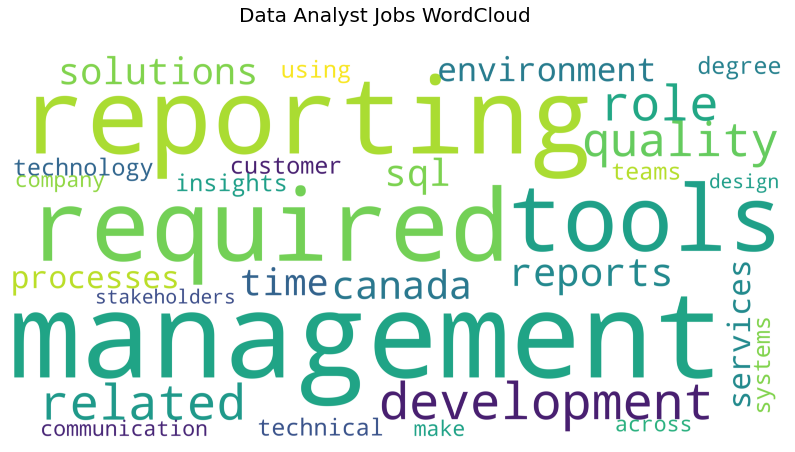

In [28]:
# Create a WordCloud

# Instantiate WordCloud object
wordcloud = WordCloud(background_color='white', scale=30, max_words=30)
wordcloud.generate_from_frequencies(freq_count)

# Set plot parameters
plt.figure(figsize=(14,10))
plt.axis('off')
wordcloud_plot_title = ' '.join(job_terms)
wordcloud_plot_title = wordcloud_plot_title.title()
plt.suptitle(f'{wordcloud_plot_title}' + ' ' + 'Jobs WordCloud', fontsize=20, y=0.84)
plt.imshow(wordcloud)
plt.show()

Unfortunately, this particular WordCloud is not so interesting - we'll need a much more sophisticated and deep level text analysis and cleansing in order to remove words that are not so helpful. Looking at this WordCloud, we can see that some of the most important words are data, business, experience, skills, work, and team, none of which are helpful in determining what specific skills we should target.

The level of NLP and text analysis we would need in order for this to be improved significantly is beyond the scope of this demonstration project, however we can use an alternative method that could be more useful.

Alternative: we can gather a list of common skills within analytics and data science, and check if any of the job descriptions contain these skills. The limitation of course is that our skill list may exclude some skills but we can always add to this later when we discover new skills that are rising in the field or those that have been missed.

In [36]:
# Create list of common skills in analytics and data science - this list of nearly 200 skills was compiled from various web articles highlighting the top in-demand skills in the field
# The list is compiled in an Excel file to avoid cluttering the code
# Keep list items all lower-case because all job descriptions have been processed and brought into lower-case
# We will use this list to check which job descriptions contain these skills

common_skills = pd.read_excel('common_skills.xlsx', usecols=[0])
common_skills_list = []

for w in common_skills['Skill']:
    common_skills_list.append(w)

common_skills_list

['a/b testing',
 'aggregating',
 'aggregation',
 'agile',
 'ai solutions',
 'airflow',
 'algorithm',
 'alteryx',
 'amazon',
 'analyses',
 'analytics tools',
 'apache',
 'api',
 'application programming interface',
 'artifical intelligence',
 'athena',
 'automate',
 'automated',
 'automating',
 'automation',
 'aws',
 'azure',
 'bi development',
 'bi platforms',
 'bi reporting',
 'bi solutions',
 'bi tools',
 'big data',
 'bigquery',
 'business intelligence reporting',
 'business intelligence tools',
 'cloud',
 'clustering',
 'coding',
 'dashboard',
 'data accuracy',
 'data aggregation',
 'data brick',
 'data cleaning',
 'data cleansing',
 'data cube',
 'data engineering',
 'data enhancement',
 'data exploration',
 'data extraction',
 'data flow',
 'data governance',
 'data integration',
 'data integrity',
 'data investigation',
 'data lake',
 'data loading',
 'data management',
 'data manipulation',
 'data mining',
 'data models',
 'data pipeline',
 'data processing',
 'data profiling',

In [37]:
# Create column for 'skill flag' - this will identify which skills in our common_skills list are found in each posting
skill_flag = []
for j in range(len(df['job_description'])):
    matches = [x for x in common_skills_list if x in df['job_description'].iloc[j]]
    skill_flag.append(matches)

df['skill_flag'] = skill_flag
df

,job_title,job_description,job_link,skill_flag
0,data analyst forensic disputes,job type permanent primary location multiple...,https://ca.indeed.com/rc/clk?jk=fdf59813de705f...,"[analyses, database, manipulating, queries, sql]"
1,junior data analyst,blend is a recruitment process outsourcer who...,https://ca.indeed.com/rc/clk?jk=7ace67b6efdea6...,"[dashboard, data visualization, data visualiza..."
2,junior data analyst,the revenue management opportunity we are curr...,https://ca.indeed.com/rc/clk?jk=4bdcb993fbbfdb...,"[analyses, automate, automated, automation, bi..."
3,people data analyst,who we are lululemon is a yoga inspired techni...,https://ca.indeed.com/rc/clk?jk=e546e664d82f13...,"[bi solutions, dashboard, data mining, excel, ..."
4,data analyst,req id 359760 at bell we do more than build ...,https://ca.indeed.com/rc/clk?jk=0761c0ebadc086...,"[coding, data visualization, database, excel, ..."
...,...,...,...,...
321,it data analyst,we are entering into an exciting time here at ...,https://ca.indeed.com/company/Intact-Public-En...,"[agile, excel, framework, modeling, power bi, ..."
322,treasury data analyst treasury analytics and ...,canada s challenger bank equitable group inc ...,https://ca.indeed.com/rc/clk?jk=b7afba282cdf4e...,"[automate, automated, automation, data governa..."
323,treasury data analyst treasury analytics and ...,canada s challenger bank equitable group inc ...,https://ca.indeed.com/rc/clk?jk=b7afba282cdf4e...,"[automate, automated, automation, data governa..."
324,data analyst business intelligence,see if you are our next business analyst temp...,https://ca.indeed.com/rc/clk?jk=77e398148561fb...,"[alteryx, automate, data integrity, excel, mod..."


In [38]:
# Create a list for all skills flagged - we'll run the same processing steps previously and generate a new WordCloud

all_skills_flagged = []

for i in df['skill_flag'].tolist():
    for j in i:
        all_skills_flagged.append(j)

len(all_skills_flagged)

4198

In [39]:
# Vectorize the all_skills_flagged list
vectorizer = TfidfVectorizer(input='content', use_idf=True)
vectors = vectorizer.fit_transform(all_skills_flagged).toarray()
vocab = np.array(vectorizer.get_feature_names_out())

# Check a random word in the vocabulary
random_selection = np.random.randint(len(vocab))
vocab[random_selection]

'mysql'

In [40]:
# Check scores of word importance
scores = {'Words': vocab, 'Scores': sum(vectors)}
df_scores = pd.DataFrame(data=scores)
df_scores = df_scores[df_scores['Words'] != 'data']     # Through tokenization, data gets split from phrases like "data cleansing" which is not useful on its own
df_scores.sort_values(by=['Scores'], ascending=False, inplace=True)
df_scores[:30]

,Words,Scores
135,sql,256.694677
44,excel,247.000000
116,reporting,227.463793
34,database,163.000000
59,insight,162.000000
136,ssis,144.000000
108,python,132.000000
32,dashboard,116.000000
144,tableau,114.000000
141,statistics,97.000000


In [41]:
# Calculate N most frequent words
n = 30
freq_count = collections.Counter(all_skills_flagged)

# Create new dataframe for word counts
df_word_counts = pd.DataFrame(freq_count.most_common(n), columns=['Words', 'Count'])
df_word_counts

,Words,Count
0,excel,247
1,sql,231
2,reporting,203
3,database,163
4,insight,162
5,ssis,144
6,python,132
7,dashboard,116
8,tableau,114
9,statistics,97


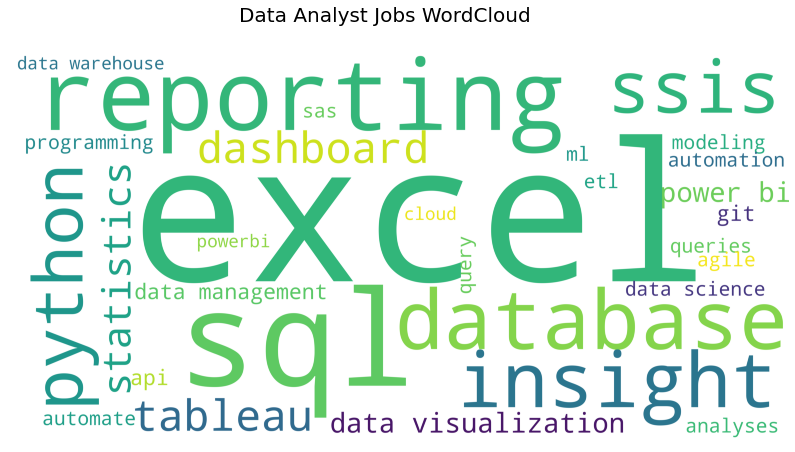

In [45]:
# Create a WordCloud

# Instantiate WordCloud object
wordcloud = WordCloud(background_color='white', scale=30, max_words=30)
wordcloud.generate_from_frequencies(freq_count)

# Set plot parameters
plt.figure(figsize=(14,10))
plt.axis('off')
wordcloud_plot_title = ' '.join(job_terms)
wordcloud_plot_title = wordcloud_plot_title.title()
plt.suptitle(f'{wordcloud_plot_title}' + ' ' + 'Jobs WordCloud', fontsize=20, y=0.84)
plt.imshow(wordcloud)
plt.show()

Conclusion:
<br>
<br>Our revised WordCloud is certainly much better and is useful to identify some of the most requested skills. The larger the text, the more prevalent that skill is. From this extraction, we see that some of the most requested skills include: Excel, SQL, SSIS, Python, Tableau, database, insight, and data visualization. This makes sense given our example job title in our search query (Data Analyst).

Limitations:
- This approach depends on maintaining a comprehensive and up-to-date skills list in which to identify matches in the job postings
- Without an extremely well suited corpus to your dataset, it is challenging to remove words that don't provide much meaning on their own as we saw in the first WordCloud
- It is very difficult to account for certain skills that are abbreviated, such as AI (this could simply be flagged as being part of a word)
- Each job posting can have a different structure, however the sections are not separated structurally. E.g. although we could possibly try to scrape what is in the Qualification sections, there are no structural elements that can isolate this section within the HTML - all job postings are essentially one large body of text

Possible Next Steps:
- Implement a true NLP model that would be able to identify the skills and qualifications within the full context of each job posting, which would then eliminate the need for a skill keyword matching approach as I have done in the revised WordCloud
- Have a process to identify "duplicate" postings that have a different URL from the original posting - ideally we don't want to count these postings twice